In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from IPython import display
import numpy as np
# %matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.r3b_2d import UNIT_TIME
from orbsim.r3b_2d.analyticals import *
from orbsim.r3b_2d.simulators import launch_sim
from orbsim.plotting import orbitplot2d, orbitplot_non_inertial
import time
from random import shuffle
from numba import jit
import math
from math import pi
import multiprocessing as mp
print(mp.cpu_count())

pi8=pi/8
pi4=pi/4
pi2=pi/2

4


In [2]:
class saddle_space:
    def __init__(self):
        self.dim = 3
    
    def fitness(self,psi):
        res,_ = launch_sim(psi, duration= 50/UNIT_TIME, max_iter=1e7)
        return [-res]
    
    @jit
    def get_bounds(self):
        return ([-pi,-pi8,2],[pi2,pi4,4])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        pass

In [3]:
class salimans_nes:
    def __init__(self, iter=10):
        super(salimans_nes, self).__init__()

        self.iter = iter  # number of steps towards estimated gradient
    
    def evolve(self, pop):
        if len(pop) == 0:
            return pop
        sigma = 0.001
        alpha = 0.003  # learningrate

        # for each iteration, jitter around starting points, and move in the
        # best direction (weighted average jitter coordinates according to
        # fitness score)
        for i in range(self.iter):

            # get the population
            wl = pop.get_x()

            # do the jittering and selection
            j = 0
            for w in wl:
#                 print(f"mutating {str(w)}")
                noise = np.random.randn(10, 3)
                wp = [[x, y, z] for [x, y, z] in np.expand_dims(w, 0) + sigma * noise]
#                 print(np.expand_dims(w, 0) + sigma * noise)

                R = np.array([-launch_sim(wi,max_iter=1e7)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
#                 print(f"R = {R}, g = {g}")
                u = alpha * g
                print(f"new individual = {str(u)}")
                w += u  # mutate the population/take the step

                pop.set_x(j, w)  # make the move previously selected
                j += 1
        return pop

    def get_name(self):
        return f"Salimans_NES"

In [ ]:
# iterations = 10
# uda=salimans_nes(iter=iterations)
# prob = pg.problem(saddle_space())
# pop = pg.population(prob=prob, size=4)    
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    p = Pool(5)
    print(p.map(f, [1, 2, 3]))

In [13]:
def pygmo_es():
    ARCHIPELAGO=True
    iterations = 10
        
    uda = salimans_nes(iter=iterations)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow
    

    if ARCHIPELAGO:
        archi = pg.archipelago(algo=uda, prob=prob, n=1, pop_size=4)
        archi.evolve()
#         print(archi) # prints description of islands contained in archipelago
#         archi.wait()
        sols = archi.get_champions_f()
        idx = sols.index(min(sols))
        sols_x = archi.get_champions_x()
        sol=sols[idx],sols_x[idx]
    else:
        pop = pg.population(prob=prob, size=4)
        pop.set_x(0,[-2.277654673852600, 0.047996554429844, 3.810000000000000])
        pop.set_x(1,[-0.138042744751570, -0.144259374836607, 3.127288444444444])
        pop.set_x(2,[-2.086814820119193, -0.000122173047640, 3.111181716545691])
        uda.evolve(pop)
        sol = (pop.champion_f, pop.champion_x)

    print("Done! best solution is:")
    print(sol)
    return sol

Done! best solution is:
(array([-373.76162261]), array([-1.32241464,  0.09784972,  2.0291268 ]))


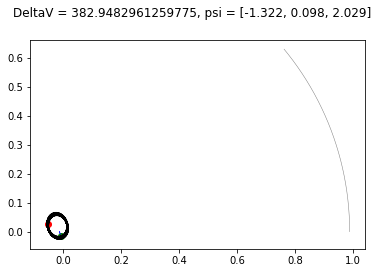

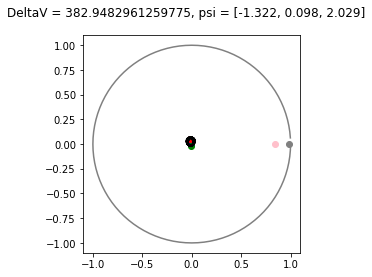

In [14]:
if __name__ == '__main__':
    Dv, psi = pygmo_es()
    path = launch_sim(psi)
    orbitplot2d(path, psi)
    orbitplot_non_inertial(path, psi)


In [ ]:
x